In [1]:
import torch
from torch import optim
import torch.nn as nn
from torch.nn import MSELoss, L1Loss
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms
from torchvision.io import read_image
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import splitext
from glob import glob
from PIL import Image
from tqdm import tqdm
import logging
from unet_model3 import UNet

In [2]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [3]:
class TheDataset(Dataset):
    def __init__(self, interlaced_dir, gtruth_dir, scale=1):
        self.interlaced_dir = interlaced_dir
        self.gtruth_dir = gtruth_dir
        self.scale = scale
        self.transform = transforms.Compose([transforms.RandomCrop(256), transforms.ToTensor()])
        
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'

        self.ids = [splitext(file)[0] for file in listdir(interlaced_dir)]
#         print(self.ids)
        print(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        pil_img = pil_img
        
        return pil_img

    def __getitem__(self, i):
        idx = self.ids[i]
        gtruth_file = glob(self.gtruth_dir + idx + '.*')
        interlaced_file = glob(self.interlaced_dir + idx + '.*')
        
        assert len(gtruth_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {gtruth_file}'
        assert len(interlaced_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {interlaced_file}'
        gtruth = Image.open(gtruth_file[0])
        interlaced = np.load(interlaced_file[0])

#         assert interlaced.size == gtruth.size, \
#             f'Image and mask {idx} should be the same size, but are {interlaced.size} and {gtruth.size}'
        
        seed = np.random.randint(2147483647) # make a seed with numpy generator 
        random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        inter1 = interlaced[:,:,0:3]
        inter1 = inter1[:,:,::-1]
        inter1 = Image.fromarray(inter1)
        inter1 = self.transform(inter1)
        inter1 = self.preprocess(inter1, self.scale)
#         plt.imshow(inter1.permute(1, 2, 0))
        
        random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        inter2 = interlaced[:,:,3:6]
        inter2 = inter2[:,:,::-1]
        inter2 = Image.fromarray(inter2)
        inter2 = self.transform(inter2)
        inter2 = self.preprocess(inter2, self.scale)
#         plt.imshow(inter2.permute(1, 2, 0))
        
        random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        inter3 = interlaced[:,:,6:9]
        inter3 = inter3[:,:,::-1]
        inter3 = Image.fromarray(inter3)
        inter3 = self.transform(inter3)
        inter3 = self.preprocess(inter3, self.scale)
#         plt.imshow(inter3.permute(1, 2, 0))
        
        random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        gtruth = self.transform(gtruth)
        gtruth = self.preprocess(gtruth, self.scale)
#         plt.imshow(gtruth.permute(1, 2, 0))
        interlaced = torch.cat((inter1, inter2, inter3), 0)
        return interlaced, gtruth
    

In [4]:
interlaced_dir = "./dataset3/interlaced/"
gtruth_dir = "./dataset3/ground_truth/"
img_scale = 1

In [5]:
batch_size = 144
val_percent = 0.2

random.seed(23)
torch.manual_seed(23)

dataset = TheDataset(interlaced_dir, gtruth_dir, img_scale)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
print(n_val, n_train)
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=24, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=24, pin_memory=True, drop_last=True)
# for inter, truth in tqdm(train_loader):

#     print(np.array(inter[0].permute(1,2,0)))
#     imshow(np.array(inter[0].permute(1,2,0)))
#     imshow(np.array(truth[0].permute(1,2,0)))
#     break

Creating dataset with 99738 examples
19947 79791


In [6]:
def train_net(idx, net, lr, losses):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-3)
    criterion = L1Loss()
    
    net.train()
    epoch_loss = 0

    ##################### TRAINING LOOP ########################
        
    for batch, (interlaced, truths) in enumerate(tqdm(train_loader)):
        interlaced = interlaced.to(device=device, dtype=torch.float32)
        truths = truths.to(device=device, dtype=torch.float32)

        net_pred = net(interlaced)
        loss = criterion(net_pred, truths)
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 46 == 0:
            loss, current = loss.item(), batch * len(interlaced)
            print(f"loss: {loss}  [{current}/{n_train}]")

    print(f"Epoch {idx+1} loss: {epoch_loss/len(train_loader)}-------------------\n")

    ##################### VALIDATION LOOP ########################
    
    test_loss = 0
    with torch.no_grad():
        net.eval()
        for batch, (interlaced, truths) in enumerate(tqdm(val_loader)):
            interlaced = interlaced.to(device=device, dtype=torch.float32)
            truths = truths.to(device=device, dtype=torch.float32)

            net_pred = net(interlaced)
            test_loss += criterion(net_pred, truths).item()

    print(f"Test loss for epoch {idx+1}: {test_loss/len(val_loader)}-------------------\n")
    losses.append((epoch_loss, test_loss))
    

In [7]:
losses = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = UNet(n_channels=9, bilinear=True)
# net = nn.DataParallel(net)
# net.to(device=device)
# lr_list = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
# for idx, lr in enumerate(lr_list):
#     print(f"Epoch {idx+1}\n-------------------------------")
#     train_net(idx=idx, net=net, lr=lr, losses=losses)
#     torch.save(net.module.state_dict(), f'model3-fixed-{idx+1}.pth')

net.load_state_dict(torch.load('model3-fixed-6.pth'))
net = nn.DataParallel(net)
net.to(device=device)
lr_list = [1e-6, 1e-6, 1e-7, 1e-7]
for idx, lr in enumerate(lr_list):
    print(f"Epoch {idx+1+5}\n-------------------------------")
    train_net(idx=idx, net=net, lr=lr, losses=losses)
    torch.save(net.module.state_dict(), f'model3-fixed-{idx+1+5}.pth')

  0%|          | 0/555 [00:00<?, ?it/s]

Epoch 6
-------------------------------


  0%|          | 1/555 [02:33<23:41:31, 153.96s/it]

loss: 0.010253196582198143  [0/79791]


  8%|▊         | 47/555 [06:08<37:52,  4.47s/it]   

loss: 0.009307022206485271  [6624/79791]


 17%|█▋        | 93/555 [10:45<34:28,  4.48s/it]  

loss: 0.011854852549731731  [13248/79791]


 25%|██▌       | 139/555 [15:21<31:09,  4.49s/it]  

loss: 0.009355681017041206  [19872/79791]


 33%|███▎      | 185/555 [19:47<27:51,  4.52s/it]  

loss: 0.009155992418527603  [26496/79791]


 42%|████▏     | 231/555 [24:14<24:38,  4.56s/it]  

loss: 0.0081398356705904  [33120/79791]


 50%|████▉     | 277/555 [28:40<21:39,  4.67s/it]  

loss: 0.011146442033350468  [39744/79791]


 58%|█████▊    | 323/555 [33:23<19:27,  5.03s/it]  

loss: 0.010981438681483269  [46368/79791]


 66%|██████▋   | 369/555 [37:58<17:03,  5.50s/it]

loss: 0.010735020972788334  [52992/79791]


 75%|███████▍  | 415/555 [42:31<15:43,  6.74s/it]

loss: 0.008754928596317768  [59616/79791]


 83%|████████▎ | 461/555 [47:01<13:37,  8.70s/it]

loss: 0.008288266137242317  [66240/79791]


 91%|█████████▏| 507/555 [51:43<11:29, 14.37s/it]

loss: 0.009493610821664333  [72864/79791]


100%|█████████▉| 553/555 [55:08<00:08,  4.47s/it]

loss: 0.008733760565519333  [79488/79791]


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 1 loss: 0.00994408962543349-------------------



100%|██████████| 138/138 [13:56<00:00,  6.06s/it] 


Test loss for epoch 1: 0.0073014211105317745-------------------



  0%|          | 0/555 [00:00<?, ?it/s]

Epoch 7
-------------------------------


  0%|          | 1/555 [02:39<24:29:23, 159.14s/it]

loss: 0.008301816880702972  [0/79791]


  8%|▊         | 47/555 [06:23<37:54,  4.48s/it]   

loss: 0.01009159255772829  [6624/79791]


 17%|█▋        | 93/555 [11:14<34:33,  4.49s/it]  

loss: 0.0093527901917696  [13248/79791]


 25%|██▌       | 139/555 [16:50<31:16,  4.51s/it]  

loss: 0.00854977685958147  [19872/79791]


 33%|███▎      | 185/555 [21:48<27:49,  4.51s/it]  

loss: 0.009095210582017899  [26496/79791]


 42%|████▏     | 231/555 [26:33<24:41,  4.57s/it]  

loss: 0.014090560376644135  [33120/79791]


 50%|████▉     | 277/555 [31:14<21:43,  4.69s/it]  

loss: 0.009382386691868305  [39744/79791]


 58%|█████▊    | 323/555 [35:47<18:54,  4.89s/it]  

loss: 0.009845894761383533  [46368/79791]


 66%|██████▋   | 369/555 [40:24<16:43,  5.39s/it]  

loss: 0.010999527759850025  [52992/79791]


 75%|███████▍  | 415/555 [44:59<14:28,  6.21s/it]

loss: 0.009928942658007145  [59616/79791]


 83%|████████▎ | 461/555 [49:45<13:09,  8.39s/it]

loss: 0.00999514665454626  [66240/79791]


 91%|█████████▏| 507/555 [54:18<09:35, 12.00s/it]

loss: 0.010840749368071556  [72864/79791]


100%|█████████▉| 553/555 [57:40<00:08,  4.47s/it]

loss: 0.013218186795711517  [79488/79791]


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 2 loss: 0.009692613578292432-------------------



100%|██████████| 138/138 [13:56<00:00,  6.06s/it] 


Test loss for epoch 2: 0.007590544403301201-------------------



  0%|          | 0/555 [00:00<?, ?it/s]

Epoch 8
-------------------------------


  0%|          | 1/555 [02:33<23:36:13, 153.38s/it]

loss: 0.008270014077425003  [0/79791]


  8%|▊         | 47/555 [06:19<37:55,  4.48s/it]   

loss: 0.00787296611815691  [6624/79791]


 17%|█▋        | 93/555 [10:51<34:31,  4.48s/it]  

loss: 0.008420182392001152  [13248/79791]


 25%|██▌       | 139/555 [15:34<30:58,  4.47s/it]  

loss: 0.00880781002342701  [19872/79791]


 33%|███▎      | 185/555 [20:10<27:37,  4.48s/it]  

loss: 0.008826694451272488  [26496/79791]


 42%|████▏     | 231/555 [24:48<24:28,  4.53s/it]  

loss: 0.008638383820652962  [33120/79791]


 50%|████▉     | 277/555 [29:28<21:31,  4.64s/it]  

loss: 0.007931862026453018  [39744/79791]


 58%|█████▊    | 323/555 [34:24<19:19,  5.00s/it]  

loss: 0.008884415030479431  [46368/79791]


 66%|██████▋   | 369/555 [39:30<17:33,  5.66s/it]  

loss: 0.009003802202641964  [52992/79791]


 75%|███████▍  | 415/555 [44:24<15:36,  6.69s/it]

loss: 0.01168590597808361  [59616/79791]


 83%|████████▎ | 461/555 [49:20<14:35,  9.32s/it]

loss: 0.00990600511431694  [66240/79791]


 91%|█████████▏| 507/555 [54:25<12:00, 15.02s/it]

loss: 0.008696315810084343  [72864/79791]


100%|█████████▉| 553/555 [57:48<00:08,  4.44s/it]

loss: 0.009022839367389679  [79488/79791]


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 3 loss: 0.009351646150923796-------------------



100%|██████████| 138/138 [14:55<00:00,  6.49s/it] 


Test loss for epoch 3: 0.0074141406980545626-------------------



  0%|          | 0/555 [00:00<?, ?it/s]

Epoch 9
-------------------------------


  0%|          | 1/555 [02:41<24:48:24, 161.20s/it]

loss: 0.010769415646791458  [0/79791]


  8%|▊         | 47/555 [06:31<37:38,  4.45s/it]   

loss: 0.00865481048822403  [6624/79791]


 17%|█▋        | 93/555 [11:28<34:13,  4.45s/it]  

loss: 0.010809286497533321  [13248/79791]


 25%|██▌       | 139/555 [16:21<30:54,  4.46s/it]  

loss: 0.009891645051538944  [19872/79791]


 33%|███▎      | 185/555 [21:12<27:38,  4.48s/it]  

loss: 0.007738747633993626  [26496/79791]


 42%|████▏     | 231/555 [25:57<24:31,  4.54s/it]  

loss: 0.008576382882893085  [33120/79791]


 50%|████▉     | 277/555 [30:34<21:26,  4.63s/it]  

loss: 0.01010140497237444  [39744/79791]


 58%|█████▊    | 323/555 [35:23<19:23,  5.02s/it]  

loss: 0.010077775456011295  [46368/79791]


 66%|██████▋   | 369/555 [40:03<16:53,  5.45s/it]  

loss: 0.010388749651610851  [52992/79791]


 75%|███████▍  | 415/555 [44:41<14:32,  6.23s/it]

loss: 0.009609510190784931  [59616/79791]


 83%|████████▎ | 461/555 [49:26<13:23,  8.55s/it]

loss: 0.007933313958346844  [66240/79791]


 91%|█████████▏| 507/555 [54:00<10:12, 12.77s/it]

loss: 0.010128344409167767  [72864/79791]


100%|█████████▉| 553/555 [57:27<00:08,  4.44s/it]

loss: 0.009200416505336761  [79488/79791]


  0%|          | 0/138 [00:00<?, ?it/s]

Epoch 4 loss: 0.009308080115934482-------------------



100%|██████████| 138/138 [13:56<00:00,  6.06s/it] 


Test loss for epoch 4: 0.007873461251079605-------------------



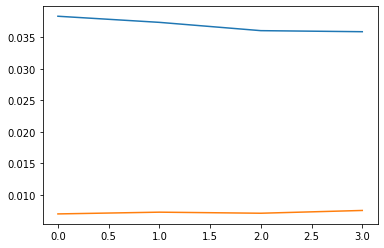

In [11]:
trainls=[]
valls=[]
for train_l, val_l in losses:
    trainls.append(train_l)
    valls.append(val_l)

plt.figure()
plt.plot(np.array(trainls)/144)
plt.plot(np.array(valls)/144)